### Goal

#### The goal of this project is to assess the language skill of 8th-12th grade English Language Learners (ELLs).Utilizing a dataset of essays written by ELLs will help to develop skill models that better supports all the students.

### Context

#### A rapidly growing student population, students learning English as a second language, known as English Language Learners(ELLs),are especially affected by the lack of practice.While automated feedback tools make it easier for teachers to assign more writing tasks.

### Data Description

#### The dataset presented here (the ELLIPSE corpus) argumentative essays written by 8th-12th grade English Language Learners (ELLs). The essays have been scored according to six analytic measures: cohesion, syntax, vocabulary, phraseology, grammar, and conventions.Each measure represents a component of skill in essay writing, with greater scores corresponding to greater skill in that measure.The scores range from 1.0 to 5.0 in increments of 0.5.

### Problem Statement

### The task is to predict the score of each of the six measures for the essays given in the data.

### Importing dependecies

In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split

### Data Gathering

In [7]:
train = pd.read_csv("train.csv")
train.head(5)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [8]:
train.shape

(3911, 8)

In [9]:
test = pd.read_csv("test.csv")
test.head(3)

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [10]:
train.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


### EDA

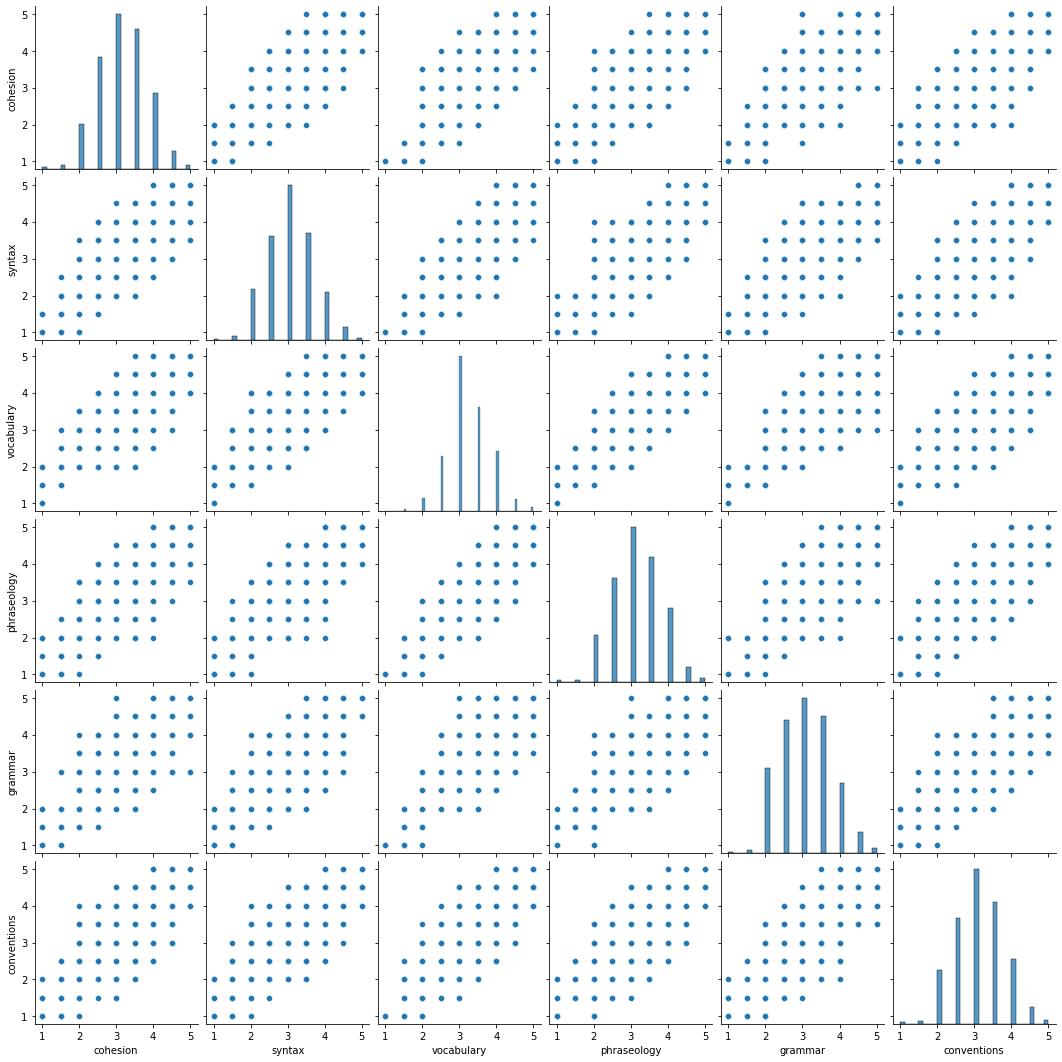

In [12]:
sns.pairplot(train)

<AxesSubplot:xlabel='cohesion', ylabel='Count'>

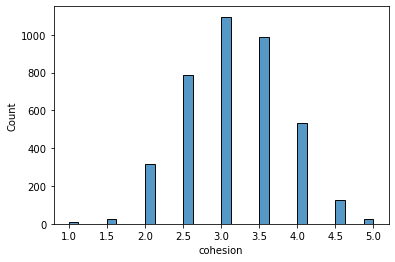

In [13]:
sns.histplot(train["cohesion"])

<AxesSubplot:xlabel='syntax', ylabel='Count'>

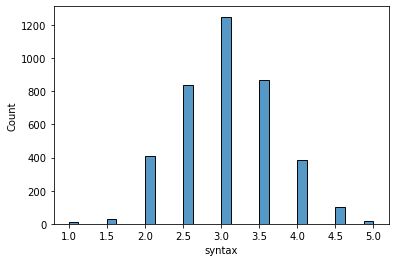

In [14]:
sns.histplot(train["syntax"])

<AxesSubplot:xlabel='vocabulary', ylabel='Count'>

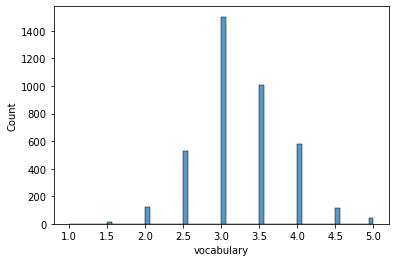

In [15]:
sns.histplot(train["vocabulary"])

<AxesSubplot:xlabel='phraseology', ylabel='Count'>

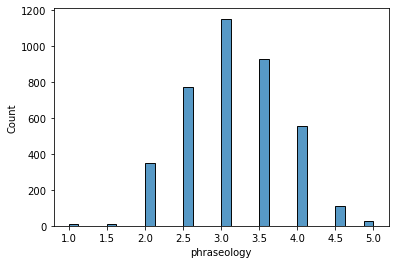

In [16]:
sns.histplot(train["phraseology"])

<AxesSubplot:xlabel='grammar', ylabel='Count'>

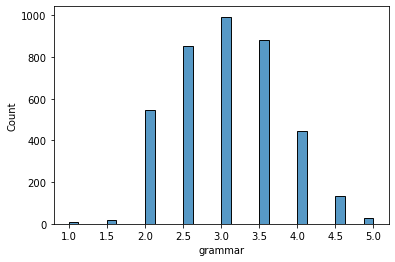

In [17]:
sns.histplot(train["grammar"])

<AxesSubplot:xlabel='conventions', ylabel='Count'>

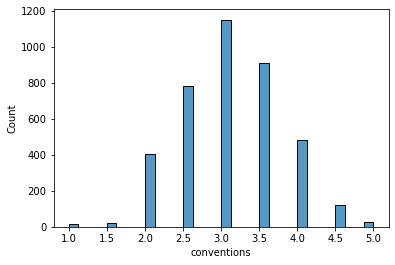

In [18]:
sns.histplot(train["conventions"])

<AxesSubplot:>

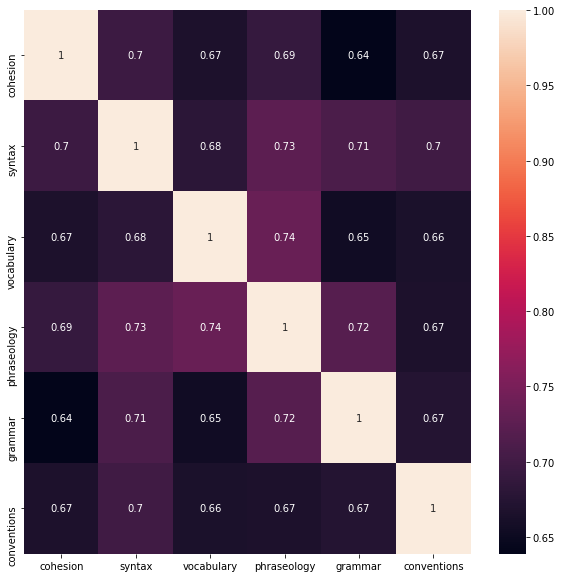

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),annot=True,color = "blue")

In [20]:
label_column =['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar',  'conventions']
target = train[label_column]
print(target)

      cohesion  syntax  vocabulary  phraseology  grammar  conventions
0          3.5     3.5         3.0          3.0      4.0          3.0
1          2.5     2.5         3.0          2.0      2.0          2.5
2          3.0     3.5         3.0          3.0      3.0          2.5
3          4.5     4.5         4.5          4.5      4.0          5.0
4          2.5     3.0         3.0          3.0      2.5          2.5
...        ...     ...         ...          ...      ...          ...
3906       2.5     3.0         3.0          3.5      2.5          2.5
3907       4.0     4.0         4.0          4.0      3.5          3.0
3908       2.5     3.0         3.0          3.0      3.5          3.0
3909       4.0     4.5         4.5          4.0      4.5          4.5
3910       3.5     2.5         3.5          3.0      3.0          3.5

[3911 rows x 6 columns]


In [21]:
text_train = train['full_text']
text_train
text_test = test['full_text']
text_test
text = text_train.append(text_test)
text

0       I think that students would benefit from learn...
1       When a problem is a change you have to let it ...
2       Dear, Principal\n\nIf u change the school poli...
3       The best time in life is when you become yours...
4       Small act of kindness can impact in other peop...
                              ...                        
3909    Many people disagree with Albert Schweitzer's ...
3910    Do you think that failure is the main thing fo...
0       when a person has no experience on a job their...
1       Do you think students would benefit from being...
2       Thomas Jefferson once states that "it is wonde...
Name: full_text, Length: 3914, dtype: object

### Seperating data and target column

In [22]:
x = text[ : len(train)]
y = target
x_test = text[len(train) : ]

In [23]:
x.shape,y.shape,x_test.shape

((3911,), (3911, 6), (3,))

### counting total words in text

In [24]:
count_words = text.str.findall(r'(\w+)').str.len()
print(count_words.sum())

1707247


### """ Cleaning Text """



In [25]:
text = text.str.lower()

In [26]:
text

0       i think that students would benefit from learn...
1       when a problem is a change you have to let it ...
2       dear, principal\n\nif u change the school poli...
3       the best time in life is when you become yours...
4       small act of kindness can impact in other peop...
                              ...                        
3909    many people disagree with albert schweitzer's ...
3910    do you think that failure is the main thing fo...
0       when a person has no experience on a job their...
1       do you think students would benefit from being...
2       thomas jefferson once states that "it is wonde...
Name: full_text, Length: 3914, dtype: object

### removing special characters and numbers

In [27]:
text = text.apply(lambda x : re.sub("[^a-z]\s","",x) )

In [28]:
text

0       i think that students would benefit from learn...
1       when a problem is a change you have to let it ...
2       dearprincipalif u change the school policy of ...
3       the best time in life is when you become yours...
4       small act of kindness can impact in other peop...
                              ...                        
3909    many people disagree with albert schweitzer's ...
3910    do you think that failure is the main thing fo...
0       when a person has no experience on a job their...
1       do you think students would benefit from being...
2       thomas jefferson once states that "it is wonde...
Name: full_text, Length: 3914, dtype: object

### remove hash tags

In [29]:
text = text.str.replace("#", "")

In [30]:
len(text)

3914

### remove words less than 3 character and greater than 7

In [31]:
text = text.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2 and len(w)<8]))

### removing stopwords

In [32]:
count_words = text.str.findall(r'(\w+)').str.len()
print(count_words.sum())

1065764


In [33]:
y = target
X = text[: len(train)]
X_test = text[len(train) :]
X.shape, X_test.shape, y.shape

((3911,), (3,), (3911, 6))

In [34]:
# from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=0.01)
X = list(map(''.join, X))


X_test = np.array(X_test).tolist()
X_test = list(map(''.join, X_test))

X_tfIdf = vectorizer_tfidf.fit_transform(X)

X_test_tfIdf = vectorizer_tfidf.transform(X_test)
print(X_test_tfIdf)
# print(X_tfIdf) 

  (0, 878)	0.0319380879962521
  (0, 876)	0.067006673829319
  (0, 859)	0.08572431936334839
  (0, 856)	0.047423621393439155
  (0, 846)	0.04094333779883599
  (0, 844)	0.08139234526226917
  (0, 818)	0.04432771296234786
  (0, 815)	0.034430955822965986
  (0, 814)	0.08737700431003928
  (0, 805)	0.060723230231364216
  (0, 798)	0.041005901504242166
  (0, 797)	0.10238070326349336
  (0, 788)	0.043194034175168296
  (0, 786)	0.053781988471103236
  (0, 785)	0.023370309564334488
  (0, 784)	0.02528924272906868
  (0, 781)	0.06767004198789241
  (0, 773)	0.0638165807296471
  (0, 760)	0.1237780209759077
  (0, 756)	0.08623903587072118
  (0, 754)	0.03417435344713567
  (0, 709)	0.05090985818497687
  (0, 699)	0.04934764279024338
  (0, 687)	0.054136095429178493
  (0, 685)	0.05812208372823719
  :	:
  (2, 385)	0.05789073541185843
  (2, 355)	0.08111022590292011
  (2, 345)	0.21427672819924495
  (2, 343)	0.07025443342682079
  (2, 341)	0.08431257442967684
  (2, 333)	0.054549304471697646
  (2, 329)	0.0499684643286357

In [35]:
X_tfIdf.shape, X_test_tfIdf.shape, y.shape

((3911, 898), (3, 898), (3911, 6))

In [36]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

chain = MultiOutputRegressor(SVR())
chain.fit(X_tfIdf, y)
print("Accuracy Score on SVR: ",chain.score(X_tfIdf,y))

Accuracy Score on SVR:  0.8679016195866956


In [37]:
predictions = chain.predict(X_test_tfIdf)
predictions

array([[2.93678038, 2.77654765, 3.17798257, 3.07834177, 2.62045559,
        2.65838625],
       [3.2433295 , 3.04838529, 3.01778122, 2.72486033, 2.75369304,
        3.21734227],
       [3.54383411, 3.39880355, 3.63049247, 3.39368284, 3.33930916,
        3.34148862]])

In [42]:
predictions = chain.predict(X_tfIdf)

MSE = mean_squared_error(y,predictions)
print("MSE for dataset",MSE)
print("     ")
rmse = np.sqrt(MSE) # if too high scale data is avaialbe then use rmse
print("rmse on dataset:",rmse)
print("     ")
r2value = r2_score(y,predictions)
print("R2 value: ",r2value)
print("     ")
adj_r1 =  1 - (((1-r2value)*(X_test_tfIdf.shape[0] - 1 ))/(X_test_tfIdf.shape[0] - X_test_tfIdf.shape[1] - 1))
print("Adjusted R score:",adj_r1)

MSE for dataset 0.056804182003165414
     
rmse on dataset: 0.23833627924251358
     
R2 value:  0.8679016195866956
     
Adjusted R score: 1.0002948624562797


In [43]:
from sklearn.linear_model import LinearRegression


In [44]:
lr_model = LinearRegression()
lr_model.fit(X_tfIdf, y)
print("Accuracy score of linear model:",lr_model.score(X_tfIdf, y))

Accuracy score of linear model: 0.4626362981241184


In [45]:
predictions =lr_model.predict(X_test_tfIdf)
predictions

array([[3.31351366, 3.05529311, 3.53230255, 3.18674618, 3.06179975,
        3.10803618],
       [3.07284939, 2.99237076, 3.05581914, 2.84716879, 2.87935841,
        3.23022917],
       [3.5522272 , 3.22390682, 3.90204725, 3.26073163, 3.47401448,
        3.31229659]])

In [46]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

### train data 

In [47]:
predictions = lr_model.predict(X_tfIdf)

MSE = mean_squared_error(y,predictions)
print("MSE for dataset:",MSE)
print("     ")
rmse = np.sqrt(MSE) # if too high scale data is avaialbe then use rmse
print("rmse on dataset:",rmse)
print("     ")
r2value = r2_score(y,predictions)
print("R2 value: ",r2value)
print("     ")
adj_r1 =  1 - (((1-r2value)*(X_test_tfIdf.shape[0] - 1 ))/(X_test_tfIdf.shape[0] - X_test_tfIdf.shape[1] - 1))
print("Adjusted R score:",adj_r1)

MSE for dataset: 0.23006196297063117
     
rmse on dataset: 0.47964774884349365
     
R2 value:  0.4626362981241184
     
Adjusted R score: 1.00119947254883


In [48]:
# y_test_predictions = lr_model.predict(X_test_tfIdf)

# MSE = mean_squared_error(y,y_test_predictions)
# print("MSE for training dataset",MSE)
# print("     ")
# rmse = np.sqrt(MSE) # if too high scale data is avaialbe then use rmse
# print("rmse on training dataset",rmse)
# print("     ")
# r2value = r2_score(y,predictions)
# print("R2 value ",r2value)
# print("     ")
# adj_r1 =  1 - (((1-r2value)*(X_test_tfIdf.shape[0] - 1 ))/(X_test_tfIdf.shape[0] - X_test_tfIdf.shape[1] - 1))
# print("Adjusted R score",adj_r1)

In [49]:
# Import the model
from xgboost import XGBRegressor

# Fit the model with training data
xgb_model = XGBRegressor(random_state=1)
xgb_model.fit(X_tfIdf,y)
print(xgb_model.score(X_tfIdf,y))
# Prediction
y_pred = xgb_model.predict(X_test_tfIdf)
y_pred
# Convert the prediction to the closest permissible value
# y_pred_new = convert_to_closest(y_pred)
# print(y_pred_new)

0.8706504075401765


array([[3.7619405, 2.8798454, 3.6302888, 3.4452612, 3.4287026, 2.830026 ],
       [3.4748585, 3.0615957, 3.3247566, 3.0616486, 3.3205805, 3.663249 ],
       [3.8059077, 3.5020795, 4.0905294, 3.8250167, 3.1268618, 3.4363067]],
      dtype=float32)

In [50]:
print(y_pred)

[[3.7619405 2.8798454 3.6302888 3.4452612 3.4287026 2.830026 ]
 [3.4748585 3.0615957 3.3247566 3.0616486 3.3205805 3.663249 ]
 [3.8059077 3.5020795 4.0905294 3.8250167 3.1268618 3.4363067]]
